# Quadrotor (aka "the drone")

## Example of how to set everything up (do this only once)

Import modules and configure the notebook.

In [1]:
import os

# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
from scipy import linalg

# This is my own script (it is an interface to the pybullet simulator)
import ae353_drone

# I often go back and forth between making changes to my scripts and to
# the notebook in which they are used. One "gotcha" is that notebooks only
# import modules or scripts ONCE. Subsequent imports don't do anything, and
# in particular won't reflect any changes I've made to my scripts. To make
# sure that I'm working with the latest version of my code, I use this bit
# of magic, which forces the notebook to "reload" my script:
import importlib
importlib.reload(ae353_drone)

<module 'ae353_drone' from 'C:\\Users\\scott\\Documents\\Jupyter\\ae353-sp21v4\\ae353-sp21\\projects\\04_drone\\ae353_drone.py'>

## Derivation of Equations of Motion

Specify the physical parameters:

In [2]:
m = sym.nsimplify(0.5)
J1 = sym.nsimplify(0.0023)
J2 = sym.nsimplify(0.0023)
J3 = sym.nsimplify(0.0040)
l = sym.nsimplify(0.175)
g = sym.nsimplify(9.81)

Derive the equations of motion:

In [3]:
# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# roll, pitch, yaw angles (radians)
phi, theta, psi = sym.symbols('phi, theta, psi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

# parameters
m = sym.nsimplify(0.5)
Jx = sym.nsimplify(0.0023)
Jy = sym.nsimplify(0.0023)
Jz = sym.nsimplify(0.0040)
l = sym.nsimplify(0.175)
g = sym.nsimplify(9.81)

# rotation matrices
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Rxyz = Rx * Ry * Rz

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry * Rz).T * ex, Rz.T * ey, ez).inv(), full=True)

# applied forces
forces = sym.Matrix([[0], [0], [-m * g]]) + Rxyz * sym.Matrix([[0], [0], [f_z]])

# euler's equations
euler = sym.Matrix([[(1 / Jx) * (tau_x + (Jy - Jz) * w_y * w_z)],
                   [(1 / Jy) * (tau_y + (Jz - Jx) * w_z * w_x)],
                   [(1 / Jz) * (tau_z + (Jx - Jy) * w_x * w_y)]])

# equations of motion
f = sym.Matrix.vstack(sym.Matrix([[v_x], [v_y], [v_z]]),
                      M * sym.Matrix([[w_x], [w_y], [w_z]]),
                      (1 / m) * forces,
                      euler)
f = sym.simplify(f, full=True)
G = sym.Matrix([[p_x], [p_y], [p_z], [phi], [theta], [psi]])
G

Matrix([
[  p_x],
[  p_y],
[  p_z],
[  phi],
[theta],
[  psi]])

## Equilibrium Values

In [4]:
p_xe = 0 
p_ye = 0
p_ze = 0


phie = 0
thetae = 0
psie = 0


v_xe = 0
v_ye = 0
v_ze = 0


w_xe = 0
w_ye = 0
w_ze = 0

tau_xe = 0
tau_ye = 0
tau_ze = 0


f_ze = (981/100)/2 

## A, B, C Matrices

In [5]:
A_num = sym.lambdify((p_x, p_y, p_z, phi, theta, psi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z) \
                   ,f.jacobian([p_x, p_y, p_z, phi, theta, psi, v_x, v_y, v_z, w_x, w_y, w_z]))
A = A_num(p_xe, p_ye, p_ze, phie, thetae, psie, v_xe, v_ye,v_ze, w_xe, w_ye, w_ze, tau_xe, tau_ye, tau_ze, f_ze)
a = sym.Matrix(A)

B_num = sym.lambdify((p_x, p_y, p_z, phi, theta, psi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z) \
                   ,f.jacobian([tau_x, tau_y, tau_z, f_z]))
B = B_num(p_xe, p_ye, p_ze, phie, thetae, psie, v_xe, v_ye,v_ze, w_xe, w_ye, w_ze, tau_xe, tau_ye, tau_ze, f_ze)
b = sym.Matrix(B)

C_num = sym.lambdify((p_x, p_y, p_z, phi, theta, psi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z) \
                   ,G.jacobian([p_x, p_y, p_z, phi, theta, psi, v_x, v_y, v_z, w_x, w_y, w_z]))
C = C_num(p_xe, p_ye, p_ze, phie, thetae, psie, v_xe, v_ye,v_ze, w_xe, w_ye, w_ze, tau_xe, tau_ye, tau_ze, f_ze)
c = sym.Matrix(C)
c

Matrix([
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

## Controllability

In [6]:
W = B
n = A.shape[0]
for i in range(1,n):
    col=np.linalg.matrix_power(A,i)@B
    W=np.block([W,col])
rank=np.linalg.matrix_rank(W)
if rank==n:
    print('Yes, system is controllable')
else:
    print('No, system is not controllable')
w=sym.Matrix(W)
#rank

Yes, system is controllable


## Observability

In [7]:
# n = C.shape[1]
# Wo = C
# for i in range(1,n):
#     col=np.linalg.matrix_power(A,i)@C
#     Wo=np.block([Wo,col])
# rank=np.linalg.matrix_rank(Wo)
# if rank==n:
#     print('Yes, system is observable')
# else:
#     print('No, system is not observable')

## LQR

In [8]:
def LQR(A,B,Q,R):
    P=linalg.solve_continuous_are(A,B,Q,R)
    K=linalg.inv(R) @ B.T @ P
    return K

## K and L Matrices

In [9]:
#Qk = np.eye(A.shape[0])
Qk = np.diag((25,75,10, 1,1,1, 5,1,5, 1,1,1))
#Rk = np.eye(B.shape[1])
Rk = np.diag((40,40,40,40))
K = LQR(A, B, Qk, Rk)
Ql = 1000*np.eye(6)
Rl = np.eye(A.shape[0])
L=LQR(A.T,C.T,linalg.inv(Rl),linalg.inv(Ql)).T
k = sym.Matrix(K)
l = sym.Matrix(L)

## Stability Check

In [10]:
Fk=A-B@K
Fl=A-L@C
eigFk=linalg.eigvals(Fk)
eigFl=linalg.eigvals(Fl)#eigFl
if (eigFk.real < 0).all() and (eigFk.real < 0).all():
    print('System is stable')
else:
    print('System is not stable: Readjust')

System is stable


## Robot Controller

Define a controller for the drone.

In [11]:
class RobotController:
    def __init__(self, limiter=None):
        self.dt = 0.01
        self.limiter = limiter
        
        self.A = A.astype(float)
        self.B = B.astype(float)
        self.C = C.astype(float)
        self.K = K.astype(float)
        self.L = L.astype(float)
        
        self.p_xe = p_xe 
        self.p_ye = p_ye
        self.p_ze = p_ze
        self.phie = phie
        self.thetae = theta
        self.psie = psie
        self.v_xe = v_xe
        self.v_ye = v_ye
        self.v_ze = v_ze
        self.w_xe = w_xe
        self.w_ye = w_ye
        self.w_ze = w_ze
        self.tau_xe = tau_xe
        self.tau_ye = tau_ye
        self.tau_ze = tau_ze
        self.f_ze = f_ze 

    def get_color(self):
        return [0., 1., 0.]

    def reset(self, pos):
        self.xhat = np.zeros((12,1))

    def run(self, pos, rpy, pos_ring, is_last_ring, pos_others):
        
        pest = np.array([self.xhat[0], self.xhat[1], self.xhat[2]])
        pest = pest.T[0]
        
        pxdes = pos_ring[0]
        pydes = pos_ring[1]
        pzdes = pos_ring[2]
        pxest = pest[0]
        pyest = pest[1]
        pzest = pest[2]
        
        err = pos_ring - pest
        
        if abs(err[1]) > .65:
            pxdes = pxdes - 1.675
        
        err = pos_ring - pest
        
        if abs(err[1]) > 2.5:
            pxdes = pxest + (3.9 * err[0]/(np.linalg.norm(err)))
            pydes = pyest + (4.8 * err[1]/(np.linalg.norm(err)))
            pzdes = pzest + (10. * err[2]/(np.linalg.norm(err)))
        else:
            pxdes = pxest + (3.9 * err[0]/(np.linalg.norm(err)))
            pydes = pyest + (3.2 * err[1]/(np.linalg.norm(err)))
            pzdes = pzest + (10. * err[2]/(np.linalg.norm(err)))
            
        #take off protocol
        if pos[0] < 2.5 and pos[1] < 2.5 and pos[2] < 1.25:
            pzdes = 5
            
        #landing protocol
        if is_last_ring and (err[0] > 1.8 or err[1] > 1.8):
            pzdes = 2.25
            
        xhatdes = np.array([[pxdes], [pydes], [pzdes], [0], [0], [0], [0], [0], [0], [0], [0], [0]])
        u = -self.K@(self.xhat-xhatdes)
        
        tau_x = u[0, 0] + self.tau_xe
        tau_y = u[1, 0] + self.tau_ye
        tau_z = u[2, 0] + self.tau_ze
        f_z = u[3, 0] + self.f_ze
        
        y = np.block([pos, rpy]).reshape(6, 1).astype(float)
        
        self.xhat = self.xhat + self.dt*(self.A@self.xhat+self.B@u-self.L@(self.C@self.xhat - y))

        if self.limiter is not None:
            tau_x, tau_y, tau_z, f_z = self.limiter(tau_x, tau_y, tau_z, f_z)

        return tau_x, tau_y, tau_z, f_z

Add the drone to the simulator. There are three arguments:

* `RobotController` is the class definition
* `'my_netid'` is the name of the drone
* `'my_image.png'` is the name of an image to use as a label (can be `None`, can be a file path)

You can call this function more than once, so long as you call it with a different drone name each time. An exception will be raised if you try to add two drones of the same name to the simulator.

Create simulator.

In [12]:
simulator = ae353_drone.Simulator(display=True, seed = 1)

In [13]:
simulator.clear_drones()
simulator.add_drone(RobotController, 'bout2', None)
simulator.camera_droneview('bout2')



Reset the drone (i.e., place it at a random location in the start ring).

In [14]:
simulator.reset()

Run simulation until `max_time` is reached or until the drone reaches the finish ring.

In [15]:
simulator.run(max_time=None)

FINISHED: drone "bout2" at time 11.40


## Example of how to get and plot results

Assume that we already did two things:

* Added a drone with the name `my_netid` to the simulator
* Ran the simulation

Get drone by name.

In [16]:
drone_name = 'bout2'
drone = simulator.get_drone_by_name(drone_name)

if drone is None:
    drone_names = '\n'.join([d['name'] for d in simulator.drones])
    msg = f'The simulator has no drone with name "{drone_name}".'
    if len(drone_names) == 0:
        msg += f' The simulator has no drones at all, in fact.'
    else:
        msg += f' The simulator has these drones:'
        msg += f'\n==========\n{drone_names}\n==========\n'
    print(msg)

Extract data.

In [17]:
data = drone['data'].copy()

Convert all lists in data to numpy arrays.

In [18]:
for key in data.keys():
    data[key] = np.array(data[key]).T

Did the drone finish? If so, what was the time at which it finished? If not, was it still running (or was there likely an error)?

In [19]:
if drone['finish_time'] is None:
    if drone['running']:
        print(f'The drone "{drone["name"]}" did not finish.')
    else:
        print(f'The drone "{drone["name"]}" did not finish and was no longer running.')
else:
    print(f'The drone "{drone["name"]}" finished with time: {drone["finish_time"]}')

The drone "bout2" finished with time: 11.4


Plot results.

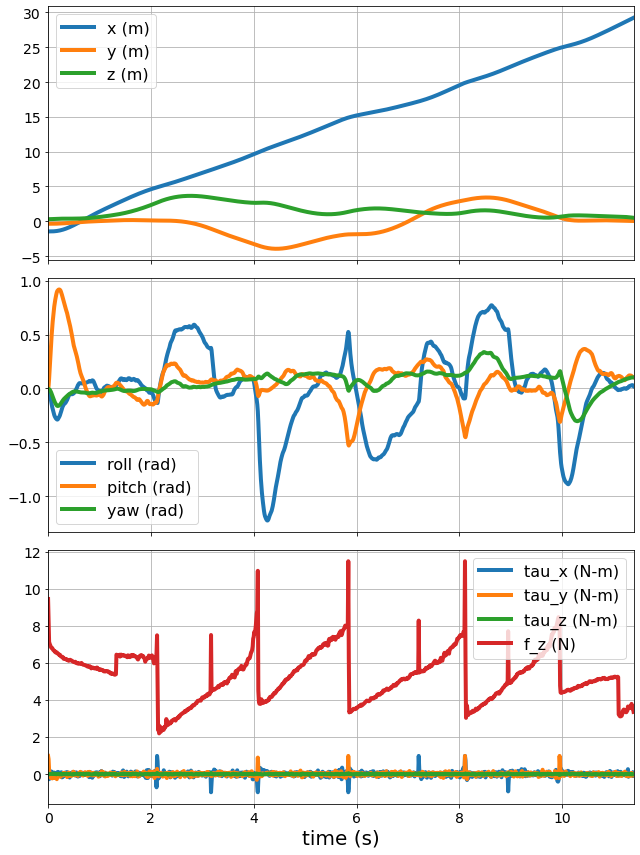

In [20]:
# Create a figure with subplots that all share the same x-axis
fig, (ax_pos, ax_rpy, ax_act) = plt.subplots(3, 1, figsize=(9, 12), sharex=True)

# Position
ax_pos.plot(data['t'], data['pos'][0, :], label='x (m)', linewidth=4)
ax_pos.plot(data['t'], data['pos'][1, :], label='y (m)', linewidth=4)
ax_pos.plot(data['t'], data['pos'][2, :], label='z (m)', linewidth=4)
ax_pos.grid()
ax_pos.legend(fontsize=16)
ax_pos.tick_params(labelsize=14)

# Roll, pitch, and yaw angles
ax_rpy.plot(data['t'], data['rpy'][0, :], label='roll (rad)', linewidth=4)
ax_rpy.plot(data['t'], data['rpy'][1, :], label='pitch (rad)', linewidth=4)
ax_rpy.plot(data['t'], data['rpy'][2, :], label='yaw (rad)', linewidth=4)
ax_rpy.grid()
ax_rpy.legend(fontsize=16)
ax_rpy.tick_params(labelsize=14)

# Actuator commands
ax_act.plot(data['t'], data['tau_x'], label='tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y'], label='tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z'], label='tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['f_z'], label='f_z (N)', linewidth=4)
ax_act.grid()
ax_act.legend(fontsize=16)
ax_act.tick_params(labelsize=14)

# Set shared x-axis properties
ax_act.set_xlabel('time (s)', fontsize=20)
ax_act.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

## Example of how to load drones from the "students" directory

Load drones from `students` directory.

In [21]:
#simulator.load_drones()

Reset drones (places drones at random positions within the start ring).

In [22]:
#simulator.reset()

Run simulation for `max_time` seconds or until all drones finish.

In [23]:
#simulator.run(max_time=5.0)

## Example of how to show results, change views, keep running

Show results (so far).

In [24]:
#simulator.show_results()

View from behind a particular drone.

In [25]:
#simulator.camera_droneview('template')

Continue running simulation from same point for `max_time` seconds or until all drones finish.

In [26]:
#simulator.run(max_time=5.0)

View from finish ring instead of from start ring.

In [27]:
#simulator.camera_finishview()

Continue running simulation from same point for `max_time` seconds or until all drones finish.

In [28]:
#simulator.run(max_time=5.0)

Show results (so far).

In [29]:
#simulator.show_results()

## Example of how to clear and reload drones

Clear all drones.

In [30]:
#simulator.clear_drones()

Load drones again from `students` directory.

In [31]:
#simulator.load_drones()

Reset drones (places drones at random positions within the start ring).

In [32]:
#simulator.reset()

Run simulation until `max_time` is reached or until all drones finish.

In [33]:
#simulator.run(max_time=5.0)

## Example of how to rearrange the rings

Rearrange the rings.

In [34]:
#simulator.move_rings()

Reset drones (places drones at random positions within the start ring).

In [35]:
#simulator.reset()

Run simulation until `max_time` is reached or until all drones finish.

In [36]:
#simulator.run(max_time=5.0)

## Example of how to take a snapshot

View from behind a particular drone.

In [37]:
#simulator.camera_droneview('template')

Display a snapshot.

In [38]:
# Get snapshot as 480 x 480 x 4 numpy array of RGBA values
#rgba = simulator.snapshot()

# Display snapshot
#plt.figure(figsize=(9, 9))
#plt.imshow(rgba)

Save the snapshot.

In [39]:
#plt.imsave('my_snapshot.png', rgba)

## Example of how to record a movie

You must install both [imageio](https://github.com/imageio/imageio) and [imageio-ffmpeg](https://github.com/imageio/imageio-ffmpeg) in order for this to work. You can do this from a terminal (in your `ae353-bullet` environment, for example) as follows:

```
pip install imageio
pip install imageio-ffmpeg
```

Reset drones (places drones at random positions within the start ring).

In [40]:
#simulator.reset()

View from behind a particular drone.

In [41]:
#simulator.camera_droneview('template')

Run simulation until `max_time` is reached or until all drones finish, saving movie to `my_video.mp4`.

In [42]:
#simulator.run(max_time=1.0, video_filename='my_video.mp4')